# Universidad Adolfo Ibañez
## Profesor Miguel Carrasco

### Alberto Bella

## Librerías

In [1]:
# import modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label
from sklearn.metrics import mean_absolute_error as mae

## Lectura y procesamiento de la imagen

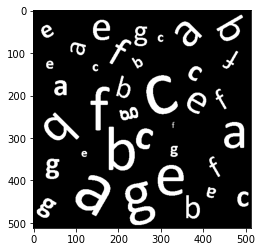

In [2]:
"""
 Universidad Adolfo Ibañez
 Facultad de Ingeniería y Ciencias
 TICS 585 - Reconocimiento de Patrones en imágenes

 Ejemplo de funcion RegionProps
 Autor:. Miguel Carrasco (26-08-2021)
 rev.1.0
"""

# read image (spanish: 'lectura de una imagen')
im = cv2.imread('sopa_letras.png')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# binarize image (spanish: 'binarizamos la imagen')
ret, bw = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV)


# label each region (spanish: 'etiquetamos cada imagen')
label_bw = label(bw)

plt.figure()
plt.imshow(bw, cmap='gray')
plt.show()

## Funciones

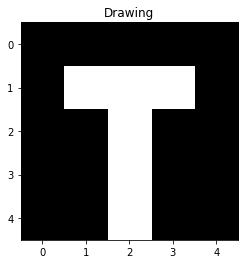

Distancia máxima: 1.7777777777777777
Distancia minima: 0.0


/tmp/ipykernel_466/883146810.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  delta = dmax/dmin


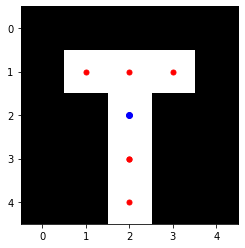

Complexity:  4.74


In [3]:
# image for test
im = [[0, 0, 0, 0, 0], \
    [0, 1, 1, 1, 0], \
    [0, 0, 1, 0, 0], \
    [0, 0, 1, 0, 0], \
    [0, 0, 1, 0, 0]]

im = np.array(im)

plt.figure()
plt.title('Drawing')
plt.imshow(im, cmap='gray')
plt.show()

# ---

# moment function
def m(i, j, r, s):
    return(np.sum((i**r)*(j**s)))

# centroid
def c(i, j):
    m10 = m(i, j, 1, 0)
    m01 = m(i, j, 0, 1)
    m00 = m(i, j, 0, 0)

    return(m10/m00, m01/m00)

# central moment function
def mu(i, j, r, s, centroid):
    return(np.sum(((i - centroid[0])**r)*((j - centroid[1])**s)))

def eta(i, j, r, s, centroid):
    t = ((r+s)/2) + 1
    num = mu(i, j, r, s, centroid)
    denom = mu(i, j, 0, 0, centroid)**t
    return(num/denom)

# hu moment function
def hu_five(i, j, centroid):
    Hu = []

    hu_1 = eta(i, j, 2, 0, centroid) + eta(i, j, 0, 2, centroid)
    Hu.append(hu_1)

    hu_2 = (eta(i, j, 2, 0, centroid) - eta(i, j, 0, 2, centroid))**2 + 4*(eta(i, j, 1, 1, centroid)**2)
    Hu.append(hu_2)

    hu_3 = (eta(i, j, 3, 0, centroid) - 3*eta(i, j, 1, 2, centroid))**2 + (3*eta(i, j, 2, 1, centroid) - eta(i, j, 0, 3, centroid))**2
    Hu.append(hu_3)

    hu_4 = (eta(i, j, 3, 0, centroid) + eta(i, j, 1, 2, centroid))**2 + (eta(i, j, 2, 1, centroid) + eta(i, j, 0, 3, centroid))**2
    Hu.append(hu_4)

    hu_5 = (eta(i, j, 3, 0, centroid) - 3*eta(i, j, 1, 2, centroid))*(eta(i, j, 3, 0, centroid) + eta(i, j, 1, 2, centroid))* \
        ((eta(i, j, 3, 0, centroid) + eta(i, j, 1, 2, centroid))**2 - 3*(eta(i, j, 2, 1, centroid) + eta(i, j, 0, 3, centroid))**2) + \
        (3*eta(i, j, 2, 1, centroid) - eta(i, j, 0, 3, centroid))*(eta(i, j, 2, 1, centroid) + eta(i, j, 0, 3, centroid))* \
        (3*(eta(i, j, 3, 0, centroid) + eta(i, j, 1, 2, centroid))**2 - (eta(i, j, 2, 1, centroid) + eta(i, j, 0, 3, centroid))**2)
    Hu.append(hu_5)

    return(Hu)

def distance(img):
    region = np.argwhere(img>0)
    binary = np.array(region, dtype='uint8')

    ## Author:. Miguel Carrasco (26-08-2021)
    #%determinamos el borde 
    #buscamos las coordenadas de los contornos 
    contours, hierarchy = cv2.findContours(np.array(img, dtype='uint8'), 
                                        cv2.RETR_EXTERNAL, 
                                        cv2.CHAIN_APPROX_NONE)

    # generamos una matriz (fila/columna) con los contornos
    contornos = np.vstack(contours[0])

    # extraemos las coordenadas x,y 
    x , y = zip(*contornos)
    x = np.array(x).reshape(-1,1)
    y = np.array(y).reshape(-1,1)

    # calculo del centro de masa
    [ci, cj] = c(region[:, 0], region[:, 1])
    
    # distancia euclidiana
    # dd = np.sqrt((x-ci)**2+(y-cj)**2)
    
    # distancia city block
    dd = np.abs(x-ci) + np.abs(y-cj)
    
    # distancia chessboard
    # dd = np.amax(np.stack((np.abs(x-ci), np.abs(y-cj)), axis=1), axis=1)

    #descriptores normalizados 
    dmean = np.mean(dd)
    dmax  = np.max(dd)/dmean
    dmin  = np.min(dd)/dmean
    delta = dmax/dmin
    features = dmax, dmin, delta, ci, cj, x, y, dmean

    return features


# first, we select the region
region = np.argwhere(im>0)

dmax, dmin, delta, ci, cj, x, y, dmean  = distance(im)
print(f'Distancia máxima: {dmax}')
print(f'Distancia minima: {dmin}')

plt.figure()
plt.imshow(im, cmap="gray")
plt.scatter(x, y, marker='.', s=100, c='red')
plt.plot(cj, ci, marker = 'o', color ='blue')
plt.show()

complex = 6/dmean**2
print('Complexity: ', round(complex, 2))

# then, we calculate centroid
# centroid = c(region[:, 0], region[:, 1])
# print(centroid)

# print(hu_five(region[:, 0], region[:, 1], centroid))


## Ejercicios

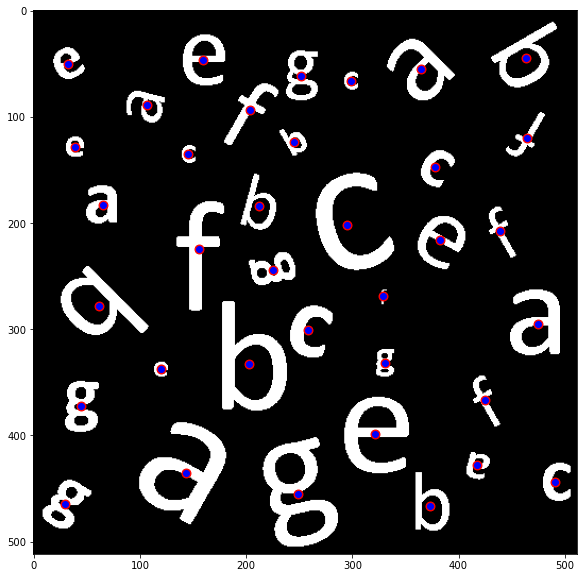

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(bw, cmap='gray')

for prop in regionprops(label_image = label_bw):
    
    # binarize the image
    binary = (prop.image*1).astype('uint8')
    # get region coord
    region = np.argwhere(binary>0)

    # get the right centroid from the general picture
    # region_centroid = c(region[:, 0], region[:, 1])
    region_centroid = (c(region[:, 0], region[:, 1])[0] + prop.bbox[0], c(region[:, 0], region[:, 1])[1] + prop.bbox[1])

    # check results
    # print(mae(prop.centroid, region_centroid))

    # print('regionprops centroid:', prop.centroid)
    plt.scatter(prop.centroid[1], prop.centroid[0], c='red', s=80)

    # print(region_centroid)
    plt.scatter(region_centroid[1], region_centroid[0], c='blue')


    ## 1. 5 hu moments
    # print(hu_five(region[:, 0], region[:, 1], c(region[:, 0], region[:, 1])))
    # print(prop.moments_hu)

    ## 2. Complexity
    # print(prop.area)

    ## 3. Perimeter or Contour
    # print(prop.perimeter)

    ## 4. Roundness

    ## 5. Ellipse angle


plt.show()

Distancia máxima: 1.7431888765128691
Distancia minima: 0.5171298477677453


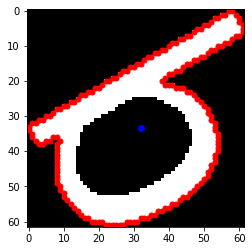

Complexity:  1.14


In [5]:
regions = regionprops(label_image = label_bw)

dmax, dmin, delta, ci, cj, x, y, dmean  = distance(regions[0].image*1)
print(f'Distancia máxima: {dmax}')
print(f'Distancia minima: {dmin}')

plt.figure()
plt.imshow(regions[0].image*1, cmap="gray")
plt.scatter(x, y, marker='.', s=100, c='red')
plt.plot(cj, ci, marker = 'o', color ='blue')
plt.show()

complex = regions[0].area/dmean**2
print('Complexity: ', round(complex, 2))

In [9]:
print(len(x))
print(len(y))

187
187
